# Transductive SVM Demonstration

For a more detailed explanation please check out my [blog post](https://ktmai.github.io/2019-11/transductive-svms/).

## SVM

Let's start with a standard SVM.

In [0]:
# Import the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_classification
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

For our toy demonstration, we will generate a 2D binary-class dataset with $X$ being the datapoints and $y$ being the corresponding labels.

In [0]:
# Generate the dataset
X, y = make_classification(n_samples=200, n_features=2, n_redundant=0, class_sep=0.4, random_state=200)

# Add a column of 1s to X to denote a bias, which will help us in our optimisation later
X = np.hstack((np.ones((X.shape[0], 1)), X))

# Since SVM scales are relative, replace the 0 class with -1
y[y == 0] = -1

In [0]:
def draw_boundary(weights, text):
  x_1 = -4
  x_2 = 4
  y_1 = -(weights[0] + weights[1]*x_1)/weights[2]
  y_2 = -(weights[0] + weights[1]*x_2)/weights[2]
  plt.plot([x_1, x_2], [y_1, y_2], label=text)
  plt.legend()

def plot_points(X, y, test=None, fit=0, weights=0, text=None):
  plt.figure(figsize=(10,10))
  colour = ['red' if label == -1 else 'blue' for label in y]
  plt.scatter(X[:,1], X[:,2], color=colour)
  if test is not None:
    plt.scatter(test[:,1], test[:,2], color='grey')
  if fit:
    draw_boundary(weights, text)
  plt.show()

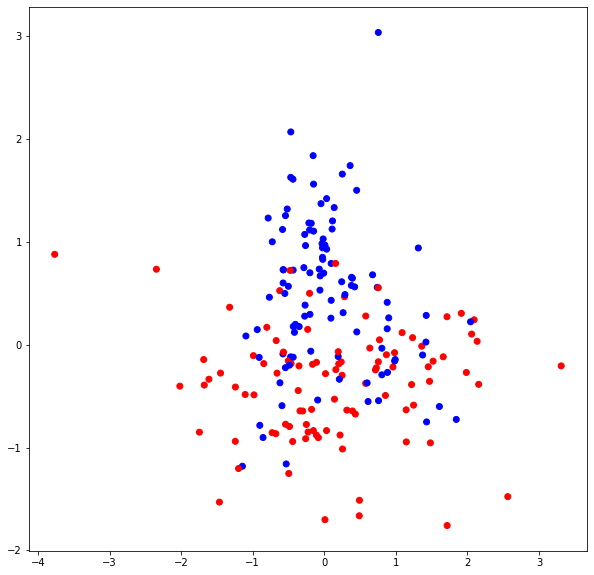

In [0]:
# Visualise the points. The red points belong to the negative class whilst the blue points belong to the positive class
plot_points(X, y)

### Using the entire dataset

In this scenario, we won't partition the data into a training and test set and instead will fit the model to the entirety of the data. Recall that the objective function can be written as follows:

$$\underset{\textbf{w}}{\textrm{min}}||\mathbf{w}||^2 + C\sum^n_{i=1} \textrm{max}(0, 1 - y^i(\textbf{w}^T\textbf{x}^i + b))$$

where $C$ is a hyperparameter. 

Let's initialise our hyperparameters, the parameters we would like to optimise, and finally define our objective function. 

In [0]:
# Set C. For this exercise we will just select one without cross validation
C = 10000

# Initialise our parameters that we'd like to optimise. We will include the bias in the first column
params = np.random.random(X.shape[1])

# Construct the objective function
def inductive_objective(params, X, y):
  # As the first column is for our bias, the remaining two columns are for "w"
  regulariser = np.sum(np.power(params[1:],2))
  # Compute the hinge loss
  loss_function = C*np.mean(np.maximum(0, 1-y*np.dot(X,params)))
  return regulariser + loss_function

We will perform optimisation through the scipy.optimise function. As the hinge loss is not smooth, we'll use the 'Nelder-Mead' method for optimisation. This is also a gradient-free option so we don't have to calculate the gradients to supply into our optimisation objective.

For more information refer to the following:

* [Scipy Documentation](https://docs.scipy.org/doc/scipy/reference/optimize.html)
* [Scipy Lecture Notes](https://scipy-lectures.org/advanced/mathematical_optimization/index.html#convex-versus-non-convex-optimization)
* [Which optimization algorithm to use?](https://cran.r-project.org/web/packages/fitdistrplus/vignettes/Optimalgo.html) (For R)

In [0]:
# Minimisation function
s1_results = minimize(inductive_objective, params, args=(X, y), method='nelder-mead')

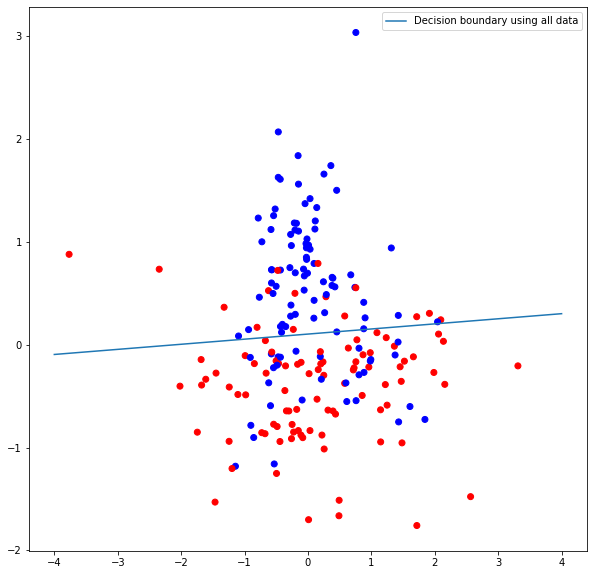

In [0]:
# Plot the results
plot_points(X, y, fit=1, weights=s1_results.x, text="Decision boundary using all data")

We can use the decision boundary to generate class predictions. This can give an indication of the performance of the SVM classifier. This would be the "ideal" performance since we are using the entire dataset.

In [0]:
def predict(X, y, weights):
  predictions = np.sign(np.dot(X, weights))
  performance = np.mean(predictions == y)*100
  print("Accuracy of the classifier: {}%".format(performance))

predict(X, y, s1_results.x)

Accuracy of the classifier: 77.5%


### Splitting into training and test data

In practice, we usually work with only a sample of the population data. We can simulate this by partitioning the dataset into training and test data.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2)

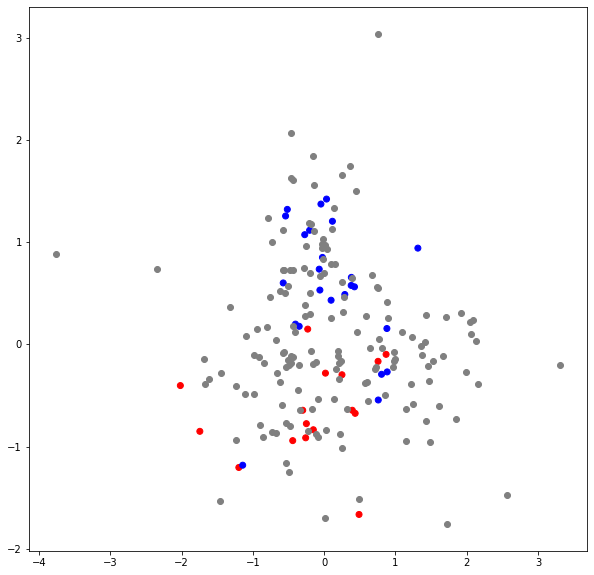

In [0]:
# Visualise the points
# In this case, the grey points are the unobserved test data
plot_points(X_train, y_train, X_test)

In [0]:
# Retrain the SVM on the training data only
s2_results = minimize(inductive_objective, params, args=(X_train, y_train), method='nelder-mead')

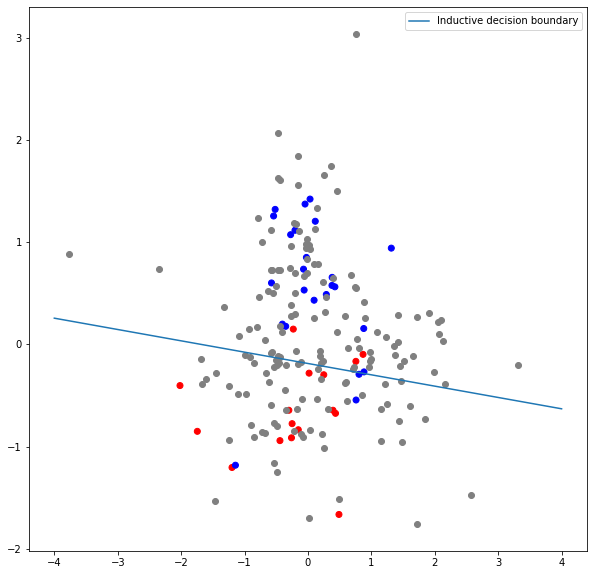

In [0]:
# Visualise the decision boundary alongside the training and test points
plot_points(X_train, y_train, X_test, fit=1, weights=s2_results.x, text="Inductive decision boundary")

In [0]:
predict(X_test, y_test, s2_results.x)

Accuracy of the classifier: 67.5%


## Transductive SVM

Recall that TSVM training incorporates both the training and test data and that its objective function can be expressed as follows:

$$\underset{\textbf{w}}{\textrm{min}}||\mathbf{w}||^2 + C\sum^m_{i=1} \textrm{max}(0, 1 - y^i(\textbf{w}^T\textbf{x}^i + b)) +C^*\sum^l_{j=1}\textrm{max}(0, 1 - |\textbf{w}^T\textbf{x}^j + b|)$$

where $C$ and $C^*$ are hyperparameters. 

We will initialise the new hyperparameter and define the new objective function.

In [0]:
# Initialise parameter for the unlabelled data
C_star = 10000

def transductive_objective(params, x_train, y_train, x_test):
  # We now have one regulariser and two hinge losses, corresponding to the training set and the test set separately
  regulariser = np.sum(np.power(params[1:],2))
  hinge_1 = C*np.mean(np.maximum(0, 1 -y_train*np.dot(x_train,params)))
  hinge_2 = C_star*np.mean(np.maximum(0, 1 - np.abs(np.dot(x_test, params))))
  return regulariser + hinge_1 + hinge_2

In [0]:
# Optimise using the new objective function
s3_results = minimize(transductive_objective, params, args=(X_train, y_train, X_test), method='nelder-mead')

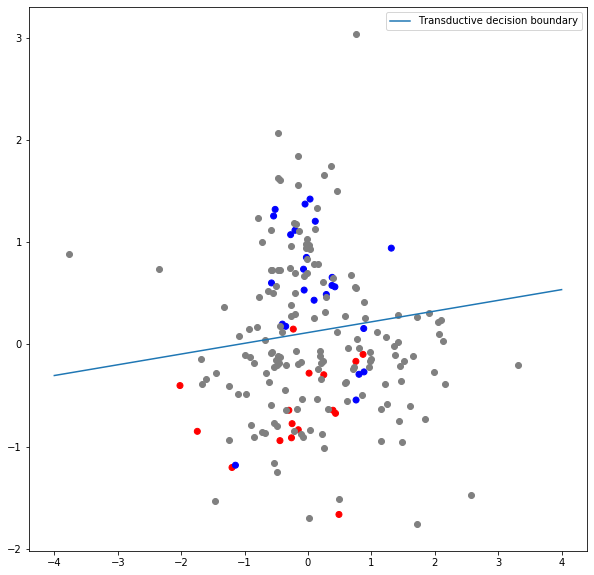

In [0]:
# Visualise the decision boundary alongside the training and test points
plot_points(X_train, y_train, X_test, fit=1, weights=s3_results.x, text="Transductive decision boundary")

In [0]:
predict(X_test, y_test, s3_results.x)

Accuracy of the classifier: 76.25%


## Summary

We can superimpose all the decision boundaries together to compare the three scenarios.

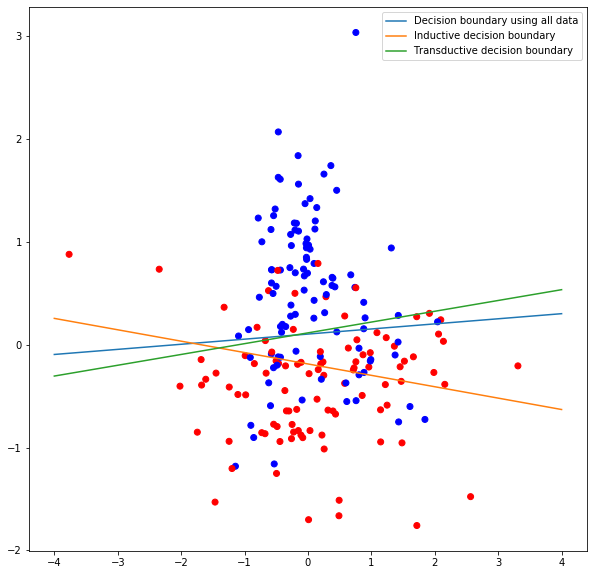

In [0]:
plt.figure(figsize=(10,10))
colour = ['red' if label == -1 else 'blue' for label in y]
plt.scatter(X[:,1], X[:,2], color=colour)
draw_boundary(s1_results.x, "Decision boundary using all data")
draw_boundary(s2_results.x, "Inductive decision boundary")
draw_boundary(s3_results.x, "Transductive decision boundary")
plt.show()